# 07__motif_coverage
# analyzing how motif coverage correlates with MPRA properties and biotypes; clustering similar motifs

in this notebook, i look at how the coverage metrics (# bp covered and max coverage of motifs; done separately, see methods) look within biotypes *after* limiting to only those motifs which have been validated by a corresponding chip peak. i also make sure the results we see aren't due to redundancies in motif databases, so i cluster the motifs using MoSBAT (done separately using their webtool) and re-calculate the metrics.

------

figures in this notebook:
- **Fig 3D and 3E**: cumulative density plots of # bp covered and max motif coverage across biotypes
- **Fig S10**: heatmap of clustered motifs, and more cumulative density plots (after clustering)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from random import shuffle
from scipy import stats
from scipy import signal
from scipy.spatial import distance
from scipy.cluster import hierarchy
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
mosbat_file = "../../misc/02__mosbat/results.from_mosbat.txt"

In [4]:
chip_cov_f = "../../misc/05__fimo/All.TSS.114bp.Motifs.Intersect.Chip.ALL.txt"
cluster_cov_f = "../../misc/05__fimo/All.TSS.114bp.Cluster.ALL.txt"

## 1. import data

In [5]:
corr = pd.read_table(mosbat_file, sep="\t")

In [6]:
chip_cov = pd.read_table(chip_cov_f, sep="\t")
cluster_cov = pd.read_table(cluster_cov_f, sep="\t")
chip_cov.head()

,PromType2,TSS_id,seqID,numMotifs,numBPcovered,fragmentLength,fractionBPcovered,MaxCov
0,antisense,"NA__chr1:10518613..10518614,+","antisense__chr1:10518613..10518614,+",0,0,115,0.000000,0
1,antisense,"NA__chr1:10699247..10699265,+","antisense__chr1:10699247..10699265,+",0,0,115,0.000000,0
2,antisense,"NA__chr1:110172923..110172928,-","antisense__chr1:110172923..110172928,-",0,0,115,0.000000,0
3,antisense,"NA__chr1:110715133..110715148,-","antisense__chr1:110715133..110715148,-",1,14,115,0.121739,1
4,antisense,"NA__chr1:110912893..110912904,+","antisense__chr1:110912893..110912904,+",0,0,115,0.000000,0


## 2. plot # bp covered & max cov across biotypes -- ChIP validated motifs

In [7]:
chip_cov["log_bp_covered"] = np.log(chip_cov["numBPcovered"]+1)
chip_cov["log_max_cov"] = np.log(chip_cov["MaxCov"]+1)

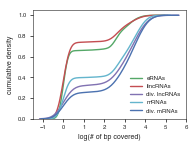

In [8]:
enh_vals = chip_cov[chip_cov["PromType2"] == "Enhancer"]["log_bp_covered"]
linc_vals = chip_cov[chip_cov["PromType2"] == "intergenic"]["log_bp_covered"]
dlnc_vals = chip_cov[chip_cov["PromType2"] == "div_lnc"]["log_bp_covered"]
pc_vals = chip_cov[chip_cov["PromType2"] == "protein_coding"]["log_bp_covered"]
dpc_vals = chip_cov[chip_cov["PromType2"] == "div_pc"]["log_bp_covered"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs")
sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs", ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs", ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs", ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs", ax=ax)
ax.set_xlabel("log(# of bp covered)")
ax.set_ylabel("cumulative density")
fig.savefig("Fig_3D.pdf", bbox_inches="tight", dpi="figure")

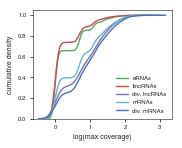

In [9]:
enh_vals = chip_cov[chip_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = chip_cov[chip_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = chip_cov[chip_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = chip_cov[chip_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = chip_cov[chip_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.5, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs")
sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs", ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs", ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs", ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs", ax=ax)
ax.set_xlabel("log(max coverage)")
ax.set_ylabel("cumulative density")
fig.savefig("Fig_3E.pdf", bbox_inches="tight", dpi="figure")

## 2. cluster the motifs using MoSBAT output

In [10]:
corr.set_index(corr["Motif"], inplace=True)
corr.drop("Motif", axis=1, inplace=True)
corr.head()

,RUNX1,TFAP2A,Arnt,Ahr..Arnt,Ar,T,PAX5,NR2F1,CREB1,Ddit3..Cebpa,...,HOXC12,HOXC13,HOXD11,HOXD13,Hoxd8,Hoxa11,Hoxd3,Hoxd9,ISL2,Hes1
Motif,,,,,,,,,,,,,,,,,,,,,
RUNX1,1.000000,0.053362,-0.045079,0.084369,-0.044827,-0.011180,0.009678,0.023699,0.031270,-0.042494,...,-0.046124,-0.054724,-0.089790,-0.021027,-0.038859,-0.082215,0.014631,-0.013418,0.029031,-0.012669
TFAP2A,0.053362,1.000000,0.060590,0.040435,0.008935,-0.033231,0.083051,0.072317,0.036212,0.012966,...,-0.142886,-0.121405,-0.172917,-0.117810,-0.184969,-0.147377,-0.089514,-0.148299,-0.072275,0.146438
Arnt,-0.045079,0.060590,1.000000,0.355305,0.065284,0.121252,-0.006139,0.048724,0.153955,0.042929,...,-0.020919,-0.022952,-0.059050,-0.077210,-0.123874,-0.067242,-0.082448,-0.073004,-0.047794,0.694827
Ahr..Arnt,0.084369,0.040435,0.355305,1.000000,0.040715,0.127365,0.061560,-0.000861,0.066961,0.022640,...,-0.027722,-0.025836,-0.058218,-0.043445,-0.090282,-0.037421,-0.068454,-0.048630,-0.033096,0.441696
Ar,-0.044827,0.008935,0.065284,0.040715,1.000000,-0.031151,-0.056479,-0.006634,0.013517,0.005174,...,-0.013779,-0.011751,-0.022109,-0.054133,-0.060648,-0.024212,0.004521,-0.034178,0.023124,0.081356


In [11]:
row_linkage = hierarchy.linkage(distance.pdist(corr, 'correlation'), method="average")
col_linkage = hierarchy.linkage(distance.pdist(corr.T, 'correlation'), method="average")

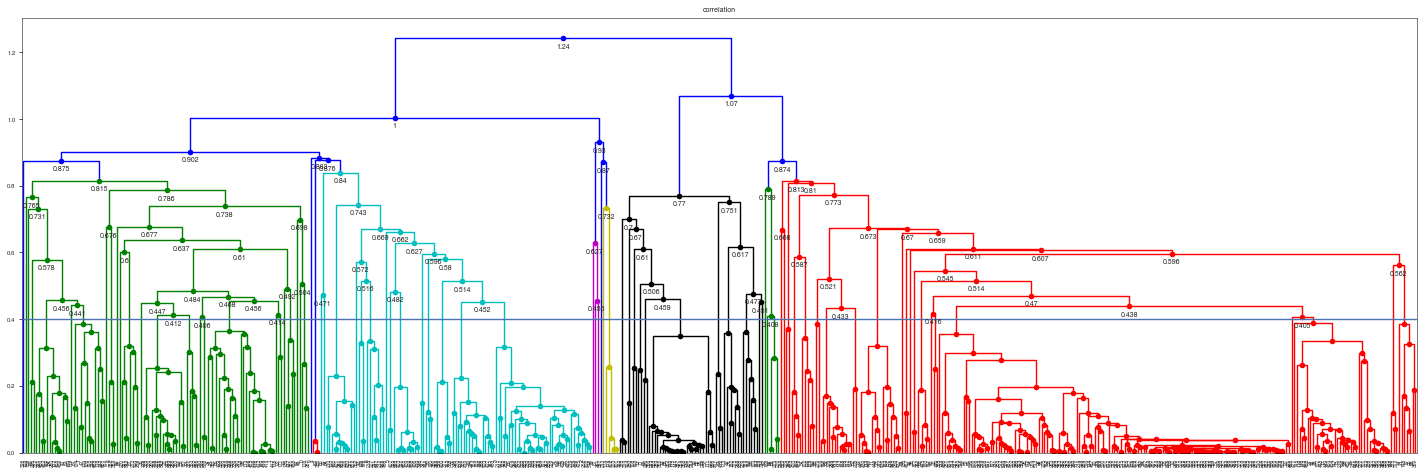

In [12]:
dists = plot_dendrogram(row_linkage, 0.4, "correlation")

In [13]:
clusters = hierarchy.fcluster(row_linkage, 0.1, criterion="distance")

In [14]:
print("n clusters: %s" % np.max(clusters))

n clusters: 223


In [15]:
cluster_map = pd.DataFrame.from_dict(dict(zip(list(corr.index), clusters)), orient="index")
cluster_map.columns = ["cluster"]
cluster_map.head()

,cluster
RUNX1,71
TFAP2A,55
Arnt,114
Ahr..Arnt,116
Ar,75


## 3. plot clustered motif heatmap

In [16]:
colors = sns.husl_palette(np.max(clusters), s=0.75)
shuffle(colors)
lut = dict(zip(range(np.min(clusters), np.max(clusters)+1), colors))
row_colors = cluster_map["cluster"].map(lut)

In [17]:
cmap = sns.cubehelix_palette(8, start=.5, light=1, dark=0.25, hue=0.9, rot=-0.75, as_cmap=True)

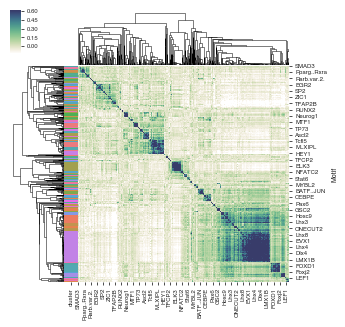

In [18]:
cg = sns.clustermap(corr, method="average", row_linkage=row_linkage, robust=True,
                    col_linkage=col_linkage, cmap=cmap, figsize=(5, 5), row_colors=row_colors,
                    linewidths=0, rasterized=True)
cg.savefig("Fig_S10A.pdf", bbox_inches="tight", dpi="figure")

## 4. re-plot # bp covered and max coverage per biotype *after* clustering
note that i sent the cluster results to marta, who re-ran her coverage scripts using them, and i re-upload them in this notebook (so in real life there is a break between the above part and the following part of this notebook)

In [19]:
cluster_cov["log_bp_covered"] = np.log(cluster_cov["numBPcovered"]+1)
cluster_cov["log_max_cov"] = np.log(cluster_cov["MaxCov"]+1)

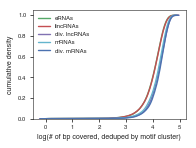

In [20]:
enh_vals = cluster_cov[cluster_cov["PromType2"] == "Enhancer"]["log_bp_covered"]
linc_vals = cluster_cov[cluster_cov["PromType2"] == "intergenic"]["log_bp_covered"]
dlnc_vals = cluster_cov[cluster_cov["PromType2"] == "div_lnc"]["log_bp_covered"]
pc_vals = cluster_cov[cluster_cov["PromType2"] == "protein_coding"]["log_bp_covered"]
dpc_vals = cluster_cov[cluster_cov["PromType2"] == "div_pc"]["log_bp_covered"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs")
sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs", ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs", ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs", ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs", ax=ax)
ax.set_xlabel("log(# of bp covered, deduped by motif cluster)")
ax.set_ylabel("cumulative density")
plt.xlim((2,5))
fig.savefig("Fig_S10B.pdf", bbox_inches="tight", dpi="figure")

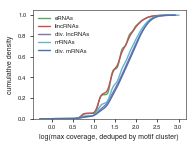

In [21]:
enh_vals = cluster_cov[cluster_cov["PromType2"] == "Enhancer"]["log_max_cov"]
linc_vals = cluster_cov[cluster_cov["PromType2"] == "intergenic"]["log_max_cov"]
dlnc_vals = cluster_cov[cluster_cov["PromType2"] == "div_lnc"]["log_max_cov"]
pc_vals = cluster_cov[cluster_cov["PromType2"] == "protein_coding"]["log_max_cov"]
dpc_vals = cluster_cov[cluster_cov["PromType2"] == "div_pc"]["log_max_cov"]

fig = plt.figure(figsize=(2.75, 2))
ax = sns.kdeplot(data=enh_vals, cumulative=True, color=TSS_CLASS_PALETTE["Enhancer"], 
                 label="eRNAs")
sns.kdeplot(data=linc_vals, cumulative=True, color=TSS_CLASS_PALETTE["intergenic"], 
            label="lincRNAs", ax=ax)
sns.kdeplot(data=dlnc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_lnc"], 
            label="div. lncRNAs", ax=ax)
sns.kdeplot(data=pc_vals, cumulative=True, color=TSS_CLASS_PALETTE["protein_coding"], 
            label="mRNAs", ax=ax)
sns.kdeplot(data=dpc_vals, cumulative=True, color=TSS_CLASS_PALETTE["div_pc"], 
            label="div. mRNAs", ax=ax)
ax.set_xlabel("log(max coverage, deduped by motif cluster)")
ax.set_ylabel("cumulative density")
fig.savefig("Fig_S10C.pdf", bbox_inches="tight", dpi="figure")